In [30]:
import numpy as np
import pandas as pd
import UQpy as UQ # not used in python library
import scipy.stats as stat
import matplotlib as plt
from scipy.optimize import newton_krylov
from scipy.integrate import dblquad
from itertools import combinations, chain, repeat
from tqdm import trange


In [31]:
def wavy6D(x):
    '''wavy6D test function'''
    
# The features include:             
# (1) The 6 input factors are non-interacting                  
# (2) The function is "wavy" along the first 5 dimensions but with different 
#     frequencies and amplitude at different directions                                     
# (3) The last dimension (X6) is fully isensitive (dummy variable)                                         
# (4) It possess large-scale features such multi-modality (X1) 
#     to small-scale features such as roughness (X3)          
# (5) The directional variograms of X1 and X2 cross each other
    
    # check whether the input x is a dataframe
    
    if not isinstance(x, (pd.core.frame.DataFrame, pd.core.series.Series, np.ndarray, list)):
        raise TypeError('`x` must be of type pandas.DataFrame, numpy.ndarray, pd.Series, or list')
    
    if len(x) > 6:
        raise ValueError('`x` must have only five arguments at a time')
    
    y1 = -1*np.sin(2*np.pi*x[0]/2) - 0.3*np.sin(2*np.pi*x[0]/0.6)
    y2 = 0.76*(-1*np.sin(2*np.pi*(x[1]-0.2)/2)) - 0.315
    y3 = 0.12*(-1*np.sin(2*np.pi*(x[2]-0.2)/1.9)) + 0.02*(-1*np.sin(2*np.pi*x[2]/0.021)) - 0.96
    y4 = 0.12*(-1*np.sin(2*np.pi*(x[3]-0.2)/1.9))-0.97
    y5 = 0.05*(-1*np.sin(2*np.pi*(x[4]-0.2)/2))-1.02
    y6 = -1.08

    return y1 + y2 + y3 + y4 + y5 + y6

In [32]:
def linear_additive(x):
    term1 = 2*x[0]
    term2 = 3*x[1]
    return term1 + term2

In [33]:
def ishigami(x, a=7, b=0.1):
    '''Ishigami test function'''
    # check whether the input x is a dataframe
    
    if not isinstance(x, (pd.core.frame.DataFrame, pd.core.series.Series, np.ndarray, list)):
        raise TypeError('`x` must be of type pandas.DataFrame, numpy.ndarray, pd.Series, or list')
    
    if x.shape[0] > 3:
        raise ValueError('`x` must have only three arguments at a time')
    
    return np.sin(x[0]) + a*(np.sin(x[1])**2) + b*(x[2]**4)*np.sin(x[0])

In [34]:
def factor_ranking(factors):
    # gather indices for sorting factor
    temp = np.argsort(factors)[::-1]
    # create an array the same shape and type as temp
    ranks = np.empty_like(temp)
    # rank factors
    ranks[temp] = np.arange(len(factors))

    return ranks
    

In [35]:
# helper functions
def apply_unique(func, df, axis=1, *args, **kwargs):
    '''Apply a function to unique rows of a DataFrame
    for efficiency.'''

    applied_df = df.merge(df.drop_duplicates()
                         .assign(**{func.__name__: lambda x: x.apply(func, axis=axis)}), 
                         how='left')
    applied_df.index = df.index
    
    return applied_df
    
    
def scale(df, bounds, axis=1, *args, **kwargs):
    '''scale the sampled matrix
    bounds is a dict with ['ub', 'lb'] keys
    the values are lists of the upper and lower bounds
    of the parameters/variables/factors'''
    
    # numpy equivalent for math operations
    bounds_np = {key:np.array(value) for key,value in bounds.items()}
    display(bounds_np)
    
    if axis:
        return df * (bounds_np['ub'] - bounds_np['lb']) + bounds_np['lb']
    else:
        return df.T * (bounds_np['ub'] - bounds_np['lb']) + bounds_np['lb']
    
    
def pairs_h(iterable):
    '''gives the pairs of numbers considering their differences'''
    interval = range(min(iterable), max(iterable)-min(iterable))
    pairs  = {key+1:[j for j in combinations(iterable, 2) if np.abs(j[0]-j[1])==key+1] for key in interval}
    return pairs
    
    
def section_df(df, delta_h): # ***delta_h here is newly added*** July 6th, 2021 - Saman's comment
    '''gets the paired values of each section based on index'''
    pairs = pairs_h(df.index.get_level_values(-1))
    df_values = df.to_numpy()
    sample = pd.concat({h*delta_h:
                    pd.DataFrame.from_dict({str(idx_tup): [df_values[idx_tup[0]], df_values[idx_tup[1]]] for idx_tup in idx}, 'index') \
                      for h, idx in pairs.items()}) 

    return sample
    
    
# lambda functions
'''covariogram of each section'''
cov_section = lambda pair_cols, mu_star: (pair_cols.sub(mu_star, axis=0)[0] * pair_cols.sub(mu_star, axis=0)[1]).groupby(level=[0,1,2]).mean()

'''variogram over all sections'''
variogram = lambda pair_cols: 0.5*(pair_cols[0] - pair_cols[1]).pow(2).groupby(level=[1,2]).mean()

'''morris sensitivity measure equivalent evaluated over all sections'''
morris_eq = lambda pair_cols: ((pair_cols[1] - pair_cols[0]).abs().groupby(level=[1,2]).mean(), \
                               (pair_cols[1] - pair_cols[0]).groupby(level=[1,2]).mean())

'''covariogram over all sections'''
covariogram = lambda pair_cols, mu_overall: ((pair_cols - mu_overall)[0] * (pair_cols - mu_overall)[1]).groupby(level=[1,2]).mean()

'''expected covariogram over all sections'''
e_covariogram = lambda cov_section_all: cov_section_all.groupby(level=[1,2]).mean()

'''sobol (total order) sensitivity measure equivalent evaluated over all sections''' # new sobol added *** 6 July 2021
# sobol_eq = lambda gamma, ecov, variance: ((gamma + ecov) / variance).loc[:,1]
sobol_eq = lambda gamma, ecov, variance, delta_h: ((gamma + ecov) / variance)[:, delta_h] # new July 6, 2021



# ivars function
def ivars(variogram_array, scale, delta_h):
    '''generate Integrated Variogram Across a Range of Scales (IVARS)
    by approximating area using right trapezoids having width of `delta_h`
    and hights of variogram values'''
    
    x_bench = [0] + variogram_array.index.dropna().get_level_values(1).to_list()
    x_int  = np.arange(start=0, stop=(scale*10+1)/10, step=delta_h)

    # calculate interpolated values for both x (h) and y (variogram)
    if x_int[-1] < scale:
        x_int.append(scale)
    y_bench= [0] + variogram_array.to_list()
    
    y_int  = np.interp(x=x_int, xp=x_bench, fp=y_bench)
    
    # for loop for each step size to caluclate the area
    ivars = 0
    for i in range(len(x_int)-1):
        ivars += 0.5*(y_int[i+1] + y_int[i]) * (x_int[i+1] - x_int[i])

    return ivars

# alias
ind = pd.IndexSlice

In [36]:
from tqdm.autonotebook import tqdm

def apply_unique(func, df, axis=1, *args, **kwargs):
    '''Apply a function to unique rows of a DataFrame
    for efficiency.'''
    
    tqdm.pandas(desc=func.__name__ + ' evaluation')

    applied_df = df.merge(df.drop_duplicates()
                         .assign(**{func.__name__: lambda x: x.progress_apply(func, axis=axis)}), 
                         how='left')
    applied_df.index = df.index
    
    return applied_df

In [37]:
def reorder_pairs(pair_df, num_stars, parameters, df, delta_h, xmax, xmin):
    # gather the actual 'h' differences between each star point value for every pair
    # possibly find a faster way to do this later
    dist_list = []
    param_names = list(parameters.keys())
    for star_centre in tqdm(range(0, num_stars), desc = 'calculating \'h\' values'):
        param_num=0
        for param in parameters.keys():
            pairs = pairs_h(df.loc[star_centre, param][param_names[param_num]].index.get_level_values(-1))
            for ignore, idx in pairs.items():
                for idx_tup in idx:
                    # note: the distances are being scaled between 0-1, and the star points have not been scaled so the pair indices will not have the same h value in the star point data frame
                    dist_list.append(np.abs((df.loc[star_centre, param][param_names[param_num]][idx_tup[0]] - df.loc[star_centre, param][param_names[param_num]][idx_tup[1]])/(xmax[param_num]-xmin[param_num])))
            param_num = param_num + 1
    
    # loading bar for binning and reording pairs based on new 'h' values
    pairs_pbar = tqdm( desc='binning and reording pairs based on \'h\' values', total=2, dynamic_ncols=True)
    
    # add new distances to dataframe
    pair_df['actual h'] = dist_list
    
    # create bin ranges
    num_bins = int(1/delta_h) # the number of bins created by delta h
    bins = np.zeros(num_bins+1)
    bins[1:] = np.arange(start=delta_h/2, step=delta_h, stop=1) # create middle bin ranges
    
    
    # create labels for the bin ranges which will be the actual delta h values
    labels = np.zeros(num_bins)
    labels[0] = delta_h/4
    labels[1:] = np.arange(start=delta_h, step=delta_h, stop=1)
    
    # bin pair values according to their distances 'h' for each paramter at each star centre
    binned_pairs = []
    for star_centre in range(0, num_stars):
        for param in parameters.keys():
            binned_pairs.append(pd.cut(pair_df.loc[star_centre, param, :]['actual h'], bins=bins, labels=labels).sort_values())
    
    # put binned pairs into a panda series
    binned_pairs = pd.concat(binned_pairs, ignore_index=False)
    
    pairs_pbar.update(1)
    
    # re order pairs values according to the bins
    centres = pair_df.index.get_level_values(0).to_numpy()
    params = pair_df.index.get_level_values(1).to_numpy()
    bps = binned_pairs.index.to_numpy()
    new_index = pd.MultiIndex.from_arrays([centres, params, bps], names = ['centre', 'param', 'pair_ind'])
    pair_df = pair_df.reindex(new_index)
    
    # add in new index h, according to bin ranges
    # ex.) h = 0.1 = [0-0.15], h = 0.2 = [0.15-0.25]
    h = list(binned_pairs.values)
    pair_df['h'] = h
    
    # format data frame so that it works properly with variogram analsysis functions
    pair_df.set_index('h', append=True, inplace=True)
    pair_df.set_index('actual h', append=True, inplace=True)
    
    pair_df = pair_df.reorder_levels(['centre', 'param', 'h', 'actual h', 'pair_ind'])
    
    pairs_pbar.update(1)
    pairs_pbar.close()
    
    return pair_df

In [38]:
def find_boundaries(parameters):
    # store parameter info in a list
    param_info = list(parameters.values()) 
    
    # store the max and min values of each paramter in arrays
    xmin = np.zeros(len(parameters))
    xmax = np.zeros(len(parameters))
    for i in range(0, len(parameters)):
        if param_info[i][3] == 'unif':
            xmin[i] = param_info[i][0] # lower bound
            xmax[i] = param_info[i][1] # upper bound
        elif param_info[i][3] == 'triangle':
            xmin[i] = param_info[i][0] # lower bound
            xmax[i] = param_info[i][1] # upper bound
        elif param_info[i][3] == 'norm':
            xmin[i] = param_info[i][0] - 3*param_info[i][1]
            xmax[i] = param_info[i][0] + 3*param_info[i][1]
        elif param_info[i][3] == 'lognorm':
            xmin[i] = 1
            xmax[i] = 1.25
        elif param_info[i][3] == 'expo':
            xmin[i] = 0 # change this
            xmax[i] = 0 # change this
        elif param_info[i][3] == 'gev':
            xmin[i] = 0 # change this
            xmax[i] = 0 # change this   
        elif param_info[i][3] == 'custom':
            xmin[i] = param_info[i][0]
            xmax[i] = param_info[i][1]
    return xmin, xmax
        

In [39]:
def rx2rn(distpair_type, param1, param2, rxpair):
    
    # getting the inverse cdf of distribution 1
    if (distpair_type[0] == 'unif'):
        mu1 = (param1[1] + param1[0])/2
        std1 = (param1[1] - param1[0])/12**0.5
        inv_cdf1 = lambda x : param1[0] + (param1[1] - param1[0])*x
    elif (distpair_type[0] == 'norm'):
        mu1 = param1[0]
        std1 = param1[1]
        inv_cdf1 = lambda x : stat.norm.ppf(x, mu1, std1)
    elif (distpair_type[0] == 'triangle'):
        mu1 = (param1[0] + param1[1] + param1[2])/3
        std1 = (np.sqrt(param1[0]**2+param1[1]**2+param1[2]**2-param1[0]*param1[1]-param1[0]*param1[2]-param1[1]*param1[2]))/np.sqrt(18)
        loc1 = param1[0]
        scale1 = param1[1] - param1[0]
        c1 = (param1[2] - param1[0])/(param1[1] - param1[0])
        inv_cdf1 = lambda x : stat.triang.ppf(q=x, c=c1, loc=loc1, scale=scale1)
    elif (distpair_type[0] == 'lognorm'):
        mu1= param1[0]
        std1=param1[1]
        # compute associated normal
        cv=std1/mu1**2
        m = np.log(mu1/(np.sqrt(1+cv)))
        v = np.sqrt(np.log(1+cv))           
        inv_cdf1 = lambda x : stat.lognorm.ppf(x, scale=np.exp(m), s=v, loc=0)
    elif (distpair_type[0] == 'expo'):
        lamda= param1[0]
        mu1=1/lamda
        std1=1/(lamda**2)
        inv_cdf1 = lambda x : stat.expon.ppf(x, scale=mu1)
    elif (distpair_type[0] == 'gev'):
        mu=param1[0] #location
        sigma=param1[1] #scale
        k1=-1*param1[2] #shape
        inv_cdf1 = lambda x : stat.genextreme.ppf(x,c=k1,scale=sigma,loc=mu);
        [mu1,std1] = stat.genextreme.stats(k1,scale=sigma,loc=mu);
        
    # getting the inverse cdf of distribution 2
    if (distpair_type[1] == 'unif'):
        mu2 = (param2[1] + param2[0])/2
        std2 = (param2[1] - param2[0])/12**0.5
        inv_cdf2 = lambda x : param2[0] + (param2[1] - param2[0])*x
    elif (distpair_type[1] == 'norm'):
        mu2 = param2[0]
        std2 = param2[1]
        inv_cdf2 = lambda x : stat.norm.ppf(x, mu2, std2)
    elif (distpair_type[1] == 'triangle'):
        mu2 = (param2[0] + param2[1] + param2[2])/3
        std2 = (np.sqrt(param2[0]**2+param2[1]**2+param2[2]**2-param2[0]*param2[1]-param2[0]*param2[2]-param2[1]*param2[2]))/np.sqrt(18)
        loc2 = param2[0]
        scale2 = param2[1] - param2[0]
        c2 = (param2[2] - param2[0])/(param2[1] - param2[0])
        inv_cdf2 = lambda x : stat.triang.ppf(q=x, c=c2, loc=loc2, scale=scale2)
    elif (distpair_type[1] == 'lognorm'):
        mu2= param2[0]
        std2=param2[1]
        # compute associated normal
        cv=std2/mu2**2
        m = np.log(mu2/(np.sqrt(1+cv)))
        v = np.sqrt(np.log(1+cv))           
        inv_cdf2 = lambda x : stat.lognorm.ppf(x, scale=np.exp(m), s=v, loc=0)
    elif (distpair_type[1] == 'expo'):
        lamda= param2[0]
        mu2=1/lamda
        std2=1/(lamda**2)
        inv_cdf2 = lambda x : stat.expon.ppf(x, scale=mu2)
    elif (distpair_type[1] == 'gev'):
        mu=param2[0] #location
        sigma=param2[1] #scale
        k2=-1*param2[2] #shape
        inv_cdf2 = lambda x : stat.genextreme.ppf(x,c=k2,scale=sigma,loc=mu)
        [mu2,std2] = stat.genextreme.stats(k2,scale=sigma,loc=mu)
    
    # bivariate standard normal distribution
    stdnorm2_pdf = lambda x1, x2 : np.exp(-1*(x1**2 + x2**2)/2.0)/(2.0*np.pi)

    # integral bound zmax=5.0, zmin = -5.0
    integrand = lambda x1, x2 : inv_cdf1(stat.norm.cdf(x1*np.sqrt(1-rxpair**2)+ rxpair*x2,0,1))*inv_cdf2(stat.norm.cdf(x2,0,1))*stdnorm2_pdf(x1, x2)
    # compute double integral of integrand with x1 ranging from -5.0 to 5.0 and x2 ranging from -5.0 to 5.0
    integral_val = dblquad(integrand, -5, 5, lambda x : -5, lambda x : 5, epsabs=1.49e-06, epsrel=1.49e-06)[0]
    rn = (integral_val - mu1*mu2)/(std1*std2)
    
    return rn

In [40]:
def rn2rx(distpair_type, param1, param2, rnpair):    
    fun = lambda r : (rnpair - rx2rn(distpair_type, param1, param2, r))
    # try to find point x where fun(x) = 0
    #try:
    rx = newton_krylov(F=fun, xin=rnpair, x_tol=1e-5)
    #except:
    #    print("Function could not converge, fictive matrix was not computed")
    #    rx = rnpair
            
    return rx    

In [41]:
def map_2_cornorm(parameters, corr_mat):
    # store parameter info in a list
    param_info = list(parameters.values())
    
    corr_n = np.eye(corr_mat.shape[0], corr_mat.shape[1])
    for i in range(0, corr_mat.shape[0] - 1):
        for j in range(i+1, corr_mat.shape[0]):
            # input paramter
            corr_n[i][j] = rn2rx([param_info[i][3], param_info[j][3]], [param_info[i][0], param_info[i][1], param_info[i][2]],[param_info[j][0], param_info[j][1], param_info[j][2]],corr_mat[i][j])
            # matrix is symmetrical
            corr_n[j][i] = corr_n[i][j]
    return corr_n

In [42]:
# not used in python library
def map_2_cornorm_uqpy(parameters, corr_mat):
    # store parameter info in a list
    param_info = list(parameters.values())
    
    # list that holds the distributions
    dist_object = []
    
    # put each paramter in its corresponding distribution
    for i in range(0, len(parameters)):
        if param_info[i][3] == 'unif':
            dist_object.append(UQ.Distributions.Uniform(loc=param_info[i][0], scale=param_info[i][1]))
        elif param_info[i][3] == 'norm':
            dist_object.append(UQ.Distributions.Normal(loc=param_info[i][0], scale=param_info[i][1]))
        # UQpy does not have a triangle distribution
        #elif param_info[i][3] == 'triangle':
            # dist_object.append(UQ.Distributions.)
        elif param_info[i][3] == 'lognorm':
            dist_object.append(UQ.Distributions.Lognormal(scale=np.exp(param_info[i][0]), s=param_info[i][1], loc=0))
        elif param_info[i][3] == 'expo':
            dist_object.append(UQ.Distributions.Exponential(loc=param_info[i][0], scale=param_info[i][1]))
        elif param_info[i][3] == 'gev':
            dist_object.append(UQ.Distributions.GenExtreme(c=param_info[i][2], loc=param_info[i][0], scale=param_info[i][1]))

    # do nataf transformation on correlation matrix
    nataf_obj = UQ.Transformations.Nataf(dist_object=dist_object, corr_x=corr_mat)

    
    return nataf_obj.corr_z

In [43]:
def n2x_transform(norm_vectors, parameters, filename):
    # Transform from correlated standard normal to original distributions
    
    k = norm_vectors.shape[1]  
    x = np.zeros(norm_vectors.shape)
    i = 0
    
    for param in parameters.keys():
        if parameters[param][3] == 'unif':
            lb = parameters[param][0]
            ub = parameters[param][1]
            
            x[:, i] = lb + (ub - lb)*stat.norm.cdf(norm_vectors[:, i],0,1)
        elif parameters[param][3] == 'norm':
            mu = parameters[param][0]
            std = parameters[param][1]

            x[:, i] = stat.norm.ppf(stat.norm.cdf(norm_vectors[:, i],0,1), mu, std)
        elif parameters[param][3] == 'triangle':
            a = parameters[param][0]
            b = parameters[param][1]
            c = parameters[param][2]
            mid = (c-a)/(b-a)
            term1 = (b-a)*(c-a)
            term2 = (b-a)*(b-c)
            x_norm = stat.norm.cdf(norm_vectors[:, i],0,1)
            x[:, i] = (a+np.sqrt(term1)*np.sqrt(x_norm))*((x_norm >= 0).astype(int))*((x_norm < mid).astype(int))+(b-np.sqrt(term2)*np.sqrt((1-x_norm)))*((x_norm >= mid).astype(int))*((x_norm < 1).astype(int))
        elif parameters[param][3] == 'lognorm':
            mu = parameters[param][0]
            std = parameters[param][1]
            term1 = std/mu**2
            m = np.log(mu/(np.sqrt(1+term1)))
            v = np.sqrt(np.log(1+term1))
            x[:, i] = np.lognorm.ppf(stat.norm.cdf(norm_vectors[:, i],0,1), scale=np.exp(mu), s=std, loc=0)
        elif parameters[param][3] == 'expo':
            mu = parameters[param][0]
            x[:, i] = np.expon.ppf(stat.norm.cdf(norm_vectors[:, i],0,1), scale=mu)
        elif parameters[param][3] == 'gev':
            mu = parameters[param][0] # location
            sigma = parameters[param][1] # scale
            k = -1*parameters[param][2] # shape
            x[:, i] = stat.genextreme.ppf(stat.norm.cdf(norm_vectors[:, i],0,1),c=k,scale=sigma,loc=mu)
        elif parameters[param][3] == 'custom':
            cdp = custom_distribution_probabilites(filename, param)
            x[:, i] = np.interp(stat.norm.cdf(norm_vectors[:, i], 0, 1), cdp['Probabilities'], cdp[param])
            
        i += 1
    
    return x

In [57]:
def custom_distribution_probabilites(filename, param):
    """
    finds empirical cdf for custom probability distribution and puts it in a dataframe for singular parameter.

    Parameters
    ----------
    filename : String
        string name of .csv file containing custom distribution data

    Returns
    -------
    cdp : array_like
        df containing custom distributions and empirical cdf
    """

    cdp = pd.read_csv(filename)
    
    # get just the singular parameter distribution
    cdp = cdp[param].to_frame().dropna(how='all').reset_index(drop=True)

    # sort data from smallest to largest
    cdp.sort_values(by=param, ignore_index=True, inplace=True)

    # find empirical cdf for all parameters
    cdp['Probabilities'] = (cdp.index + 1)/(cdp.shape[0] + 1)

    return cdp

In [72]:
# GVARS inputs
num_stars = 1000
num_dir_samples = 10
delta_h = 0.05
seed = 1234
ivars_scales = [0.1, 0.3, 0.5]
parameters = {'TDS': (681.98, 1340.8, None, 'custom'), 
             'x2': (-3.14, 3.14, None, 'unif'), 
             'Sat': (39.965, 100.56, None, 'custom'),
             'x4': (0, 1, None, 'unif'),
             'pH': (7.29, 8.782, None, 'custom'),
             'x6': (0, 1, None, 'unif')}
filename = 'Book1.csv'
corr_mat = np.array([[1, 0, 0.8, 0, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0.8, 0, 1, 0, 0, 0],
                                [0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 0, 0, 1]])
n_var = len(parameters)
n_var

6

In [73]:
#stars_pbar = tqdm(desc='generating star points', total=10, dynamic_ncols=True)
#cov_mat = map_2_cornorm_uqpy(parameters, corr_mat)
#or
#cov_mat = map_2_cornorm(parameters, corr_mat)
#stars_pbar.update(1)
cov_mat = corr_mat

In [74]:
# Generate correlated standard normal samples
# the amount of samples is the same as the amount of stars
# this is for rnd
Z = np.random.default_rng(seed=seed).multivariate_normal(np.zeros(n_var), cov=cov_mat, size=num_stars)
#stars_pbar.update(1)
Z.shape

(1000, 6)

In [23]:
#import halton, lhs, sobol_sequence
#from lhs import lhs
#from plhs import plhs
#from halton import halton
#from sobol_sequence import sobol_sequence
#from symlhs import symlhs
# Generate a set of samples from a uniform and uncorrelated
# distribution (lhs, plhs, etc.)
#J = lhs(num_stars, len(parameters), seed)
#J = plhs(sp=num_stars, params=len(parameters), seed=seed, slices=2)[0]
#J = halton(sp=num_stars, params=len(parameters), seed=seed)
#J = sobol_sequence(sp=num_stars, params=len(parameters), seed=seed)
#J = symlhs(sp=num_stars, params=len(parameters), seed=seed)

# transform J to Y, where Y is a set of normally distributed points
# with no corellation
Y = np.zeros(J.shape)
for i in range(J.shape[1]):
    Y[:, i] = stat.norm.ppf(J[:, i], 0, 1)
    
# find square root of covariance matrix using choleski method
C = np.linalg.cholesky(corr_mat)

# find normally distributed set of samples with correlation
Z = np.matmul(C, np.transpose(Y))

print(Z.shape)
print()
print(C.shape)

Z = np.transpose(Z)


NameError: name 'J' is not defined

In [77]:
# Generate Nstar actual multivariate samples X
X = n2x_transform(Z, parameters, filename)
#stars_pbar.update(1)
#np.savetxt("foo2.csv", X[:, 0], delimiter=",")
X[:, 4]

array([8.67751077, 8.4675    , 8.66      , 8.6975    , 8.32      ,
       8.2825    , 7.3275    , 8.485     , 8.5075049 , 7.59615505,
       8.6775    , 8.73383427, 8.2875    , 8.685     , 8.61      ,
       8.67      , 8.75486108, 8.4375    , 8.6125    , 8.67      ,
       7.4125    , 8.455     , 8.62      , 8.63      , 8.6854208 ,
       8.6725    , 8.665     , 8.295     , 8.61      , 7.315     ,
       8.68      , 7.3875    , 8.67      , 8.75      , 8.6375    ,
       8.4825    , 7.34050086, 8.4875    , 7.415     , 8.6225    ,
       8.515     , 8.66      , 7.32      , 8.44152404, 8.72214635,
       8.64690482, 8.59330103, 8.61200917, 8.7225    , 8.50817117,
       7.3225    , 8.6125    , 7.3825    , 8.45      , 8.65      ,
       8.2725    , 8.72      , 8.69      , 8.3175    , 7.3925    ,
       7.44629145, 8.72248118, 8.69      , 8.50372669, 8.61      ,
       8.655     , 8.67      , 8.6175    , 8.72211825, 8.635     ,
       8.67      , 8.6625    , 8.52      , 7.33912769, 7.335  

In [30]:
# define index matrix of complement subset
compsub = np.empty([n_var, n_var-1])
for i in range (0, n_var):

    temp = np.arange(n_var)
    compsub[i] = np.delete(temp, i)   
compsub = compsub.astype(int)
#stars_pbar.update(1)
compsub

array([[1, 2, 3, 4, 5],
       [0, 2, 3, 4, 5],
       [0, 1, 3, 4, 5],
       [0, 1, 2, 4, 5],
       [0, 1, 2, 3, 5],
       [0, 1, 2, 3, 4]])

In [31]:
# computer coditional variance and conditional expectation for each star center
chol_cond_std = []
std_cond_norm = []
mui_on_noti = np.zeros((len(Z), n_var))
for i in range(0, n_var):
    noti = compsub[i]
    # 2 dimensional or greater matrix case
    if (cov_mat[noti,:][:,noti].ndim >= 2):
        cond_std = cov_mat[i][i] - np.matmul(cov_mat[i,noti], np.matmul(np.linalg.inv(cov_mat[noti,:][:,noti]),cov_mat[noti,i]))
        chol_cond_std.append(np.linalg.cholesky([[cond_std]]).flatten())
        std_cond_norm.append(cond_std)
        for j in range(0, len(Z)):
            mui_on_noti[j][i] = np.matmul(cov_mat[i,noti], np.matmul(np.linalg.inv(cov_mat[noti,:][:,noti]),Z[j,noti]))
    # less then 2 dimenional matrix case
    else:
        cond_std = cov_mat[i][i] - np.matmul(cov_mat[i,noti],np.matmul(cov_mat[noti,:][:,noti],cov_mat[noti,i]))
        chol_cond_std.append(np.linalg.cholesky([[cond_std]]).flatten())
        std_cond_norm.append(cond_std)
        for j in range(0, len(Z)):
            mui_on_noti[j][i] = np.matmul(cov_mat[i, noti],np.matmul(cov_mat[noti,:][:,noti]*Z[j, noti]))
#stars_pbar.update(1)
display(std_cond_norm)
display(chol_cond_std)
display(mui_on_noti)

[0.3382584939105896,
 1.0,
 0.3382584939105896,
 0.9999999999740485,
 0.9999999999740485,
 0.9999999999740485]

[array([0.58159994]),
 array([1.]),
 array([0.58159994]),
 array([1.]),
 array([1.]),
 array([1.])]

array([[ 5.18662600e-01, -1.52203479e-17,  1.96604417e+00,
        -7.15497466e-07,  2.15787567e-06, -2.24223904e-06],
       [ 8.16659615e-01, -2.64525092e-17,  1.47437299e+00,
        -4.94365311e-06, -4.73239677e-06, -2.12188789e-06],
       [ 2.35789669e-01, -1.49606989e-17,  1.09697936e+00,
         4.18956428e-06, -4.22867123e-06, -6.44330831e-06],
       [-1.15371443e-01,  1.86857072e-17, -6.90434268e-01,
         1.91207462e-06,  8.33095791e-06,  2.26233778e-06],
       [-3.85190763e-01,  1.29469608e-18, -6.93503851e-01,
        -1.50033137e-06, -3.17230733e-06,  2.87951915e-07],
       [-9.05594471e-01,  8.26127764e-18, -1.15675811e+00,
         6.25212202e-06, -6.97371022e-06, -2.50828801e-06],
       [ 1.32561620e+00,  7.18029815e-18,  6.62241737e-01,
         6.26053072e-06,  8.40531490e-07,  9.49923456e-06],
       [ 6.57187255e-01, -1.82948484e-17, -1.92978693e-01,
        -9.31375276e-06, -3.53987063e-06, -1.05732146e-06],
       [-3.94719236e-01, -1.55525671e-17, -4.001

In [32]:
# Generate directional sample:
# Create samples in correlated standard normal space
all_section_condZ = []
condZ = []
# create num_dir_samples child_seeds for reproducibility in cross sectional samples
ss = np.random.SeedSequence(seed)
child_seeds = ss.spawn(num_dir_samples)
for j in range(0, num_dir_samples):
    stnrm_base = np.random.default_rng(seed=child_seeds[j]).multivariate_normal(np.zeros(n_var), np.eye(n_var), size=num_stars) # is there a way to do this without using cholesky method?
    for i in range(0, n_var):
        condZ.append(stnrm_base[:, i]*chol_cond_std[i] + mui_on_noti[:, i])
    all_section_condZ.append(condZ.copy())
    condZ.clear()
#stars_pbar.update(1)

np.array(all_section_condZ).shape

(10, 6, 100)

In [33]:
# transform to original distribution and compute response surface
Xi_on_Xnoti = []
tmp1 = []
Xi_on_Xnoti_and_Xnoti_temp = []
Xi_on_Xnoti_and_Xnoti = []
for j in range(0, num_dir_samples):
    for i in range(0, len(parameters)):
        tmp1.append(n2x_transform(np.array([all_section_condZ[j][i]]).transpose(), [param_info[i]]).flatten())
        tmp2 = X.copy()
        tmp2[:, i] = tmp1[i]
        Xi_on_Xnoti_and_Xnoti_temp.append(tmp2.copy()) 
    # attatch results from tmp1 onto Xi_on_Xnoti and Xi_on_Xnoti_and_Xnoti
    Xi_on_Xnoti.append(tmp1.copy())
    tmp1.clear() # clear for next iteration
    Xi_on_Xnoti_and_Xnoti.append(Xi_on_Xnoti_and_Xnoti_temp.copy())
    Xi_on_Xnoti_and_Xnoti_temp.clear() # clear for next iteration
#stars_pbar.update(1)
np.array(Xi_on_Xnoti_and_Xnoti).shape # check that shape is the same as all_section condZ

(10, 6, 100, 6)

In [34]:
# Put Star points into a dataframe
params = [*parameters]
star_points = {}
points = {}
temp = np.zeros([num_dir_samples, len(parameters)])
for i in range(0, num_stars):
    for j in range(0, len(parameters)):
        for k in range(0, num_dir_samples):
            temp[k, :] = Xi_on_Xnoti_and_Xnoti[k][j][i]
        points[params[j]] = np.copy(temp)
    star_points[i] = points.copy()
#stars_pbar.update(1)

In [35]:
star_points_df = pd.concat({key: pd.concat({k: pd.DataFrame(d) for k, d in value.items()}) for key, value in star_points.items()})
star_points_df.index.names=['centre', 'param', 'points']
star_points_df.columns = parameters.keys()
#stars_pbar.update(1)
star_points_df

x1        x2        x3        x4        x5  \
centre param points                                                     
0      x1    0       1.696918 -1.699496  1.495452  0.534905  0.238830   
             1       2.113940 -1.699496  1.495452  0.534905  0.238830   
             2       2.930574 -1.699496  1.495452  0.534905  0.238830   
             3      -1.205409 -1.699496  1.495452  0.534905  0.238830   
             4      -0.656407 -1.699496  1.495452  0.534905  0.238830   
...                       ...       ...       ...       ...       ...   
99     x6    5      -2.602338 -2.429581 -1.887262  0.325578  0.982336   
             6      -2.602338 -2.429581 -1.887262  0.325578  0.982336   
             7      -2.602338 -2.429581 -1.887262  0.325578  0.982336   
             8      -2.602338 -2.429581 -1.887262  0.325578  0.982336   
             9      -2.602338 -2.429581 -1.887262  0.325578  0.982336   

                           x6  
centre param points            
0      x1    0       0.695480  
             1       0.695480  
             2       0.695480  
             3       0.695480  
             4       0.695480  
...                       ...  
99     x6    5       0.691513  
             6       0.159077  
             7       0.641366  
             8       0.888763  
             9       0.155296  

[6000 rows x 6 columns]

In [36]:
model_name = wavy6D
df = apply_unique(model_name, star_points_df, axis=1)
df.index.names=['centre', 'param', 'points']
df

wavy6D evaluation:   0%|          | 0/6000 [00:00<?, ?it/s]

x1        x2        x3        x4        x5  \
centre param points                                                     
0      x1    0       1.696918 -1.699496  1.495452  0.534905  0.238830   
             1       2.113940 -1.699496  1.495452  0.534905  0.238830   
             2       2.930574 -1.699496  1.495452  0.534905  0.238830   
             3      -1.205409 -1.699496  1.495452  0.534905  0.238830   
             4      -0.656407 -1.699496  1.495452  0.534905  0.238830   
...                       ...       ...       ...       ...       ...   
99     x6    5      -2.602338 -2.429581 -1.887262  0.325578  0.982336   
             6      -2.602338 -2.429581 -1.887262  0.325578  0.982336   
             7      -2.602338 -2.429581 -1.887262  0.325578  0.982336   
             8      -2.602338 -2.429581 -1.887262  0.325578  0.982336   
             9      -2.602338 -2.429581 -1.887262  0.325578  0.982336   

                           x6    wavy6D  
centre param points                      
0      x1    0       0.695480 -3.525529  
             1       0.695480 -4.911430  
             2       0.695480 -4.621698  
             3       0.695480 -5.189174  
             4       0.695480 -3.555941  
...                       ...       ...  
99     x6    5       0.691513 -2.467252  
             6       0.159077 -2.467252  
             7       0.641366 -2.467252  
             8       0.888763 -2.467252  
             9       0.155296 -2.467252  

[6000 rows x 7 columns]

In [37]:
# getting the paired values of each section based on `h`
tqdm.pandas(desc='building pairs')

pair_df = df[model_name.__name__].groupby(level=[0,1]).progress_apply(section_df, delta_h=delta_h)
pair_df.index.names = ['centre', 'param', 'h', 'pair_ind']
# drop irrelevant h values
pair_df = pair_df.droplevel('h')
pair_df

building pairs:   0%|          | 0/600 [00:00<?, ?it/s]

0         1
centre param pair_ind                    
0      x1    (0, 1)   -3.525529 -4.911430
             (1, 2)   -4.911430 -4.621698
             (2, 3)   -4.621698 -5.189174
             (3, 4)   -5.189174 -3.555941
             (4, 5)   -3.555941 -5.265833
...                         ...       ...
99     x6    (1, 8)   -2.467252 -2.467252
             (2, 9)   -2.467252 -2.467252
             (0, 8)   -2.467252 -2.467252
             (1, 9)   -2.467252 -2.467252
             (0, 9)   -2.467252 -2.467252

[27000 rows x 2 columns]

In [38]:
# bin and reorder pairs based on 'h'
# note: the distances are being scaled between 0-1 inside the reorder_pairs function, and the star points have not been scaled 
# so the pair indices will not have the same h value in the star point data frame
xmin, xmax = find_boundaries(parameters)
display(xmax)
display(xmin)
pair_df = reorder_pairs(pair_df, num_stars, parameters, df, delta_h, xmax, xmin)
# include a column conaining the dissimilarity between pairs
pair_df['dissimilarity'] = 0.5*(pair_df[0] - pair_df[1]).pow(2)
pair_df

array([3.14, 3.14, 3.14, 1.  , 1.  , 1.  ])

array([-3.14, -3.14, -3.14,  0.  ,  0.  ,  0.  ])

calculating 'h' values:   0%|          | 0/100 [00:00<?, ?it/s]

binning and reording pairs based on 'h' values:   0%|          | 0/2 [00:00<?, ?it/s]

0         1  dissimilarity
centre param h    actual h pair_ind                                   
0      x1    0.05 0.066405 (0, 1)   -3.525529 -4.911430       0.960361
                  0.059176 (6, 9)   -4.351833 -5.371777       0.520142
                  0.026442 (7, 9)   -5.395680 -5.371777       0.000286
                  0.032734 (6, 7)   -4.351833 -5.395680       0.544808
                  0.064633 (8, 9)   -5.638011 -5.371777       0.035440
...                                       ...       ...            ...
99     x6    0.60 0.583062 (2, 6)   -2.467252 -2.467252       0.000000
             0.65 0.661916 (1, 9)   -2.467252 -2.467252       0.000000
                  0.658135 (1, 6)   -2.467252 -2.467252       0.000000
             0.75 0.733468 (8, 9)   -2.467252 -2.467252       0.000000
                  0.729686 (6, 8)   -2.467252 -2.467252       0.000000

[27000 rows x 3 columns]

In [32]:
vars_pbar = tqdm( desc='VARS Analysis', total=10, )

VARS Analysis:   0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
# mu_star calculation

vars_pbar.update(1)
vars_pbar.write('Averages of model runs (`mu_star`) calculated - access via .mu_star_df')


mu_star_df = df[model_name.__name__].groupby(level=[0,1]).mean()
mu_star_df.index.names = ['centre', 'param']
mu_star_df.unstack(level=1)

Averages of model runs (`mu_star`) calculated - access via .mu_star_df


param,x1,x2,x3,x4,x5,x6
centre,,,,,,
0,-4.654264,-4.139239,-4.404253,-4.215012,-4.262093,-4.275912
1,-4.092808,-3.662666,-3.348335,-3.177758,-3.216120,-3.226206
2,-4.624104,-4.316365,-4.775642,-4.740424,-4.784893,-4.804459
3,-4.903892,-4.231553,-5.371590,-5.280495,-5.315362,-5.322594
4,-5.586995,-4.578027,-5.462929,-5.354736,-5.363663,-5.389711
...,...,...,...,...,...,...
95,-4.008283,-3.941521,-3.210074,-3.094449,-3.118176,-3.132468
96,-4.819170,-4.162244,-3.507697,-3.566572,-3.619669,-3.645327
97,-4.444610,-3.459476,-3.734015,-3.508694,-3.568053,-3.590191


In [34]:
# overall mu (mean) of the unique evaluated function values over all stars points

vars_pbar.update(1)
vars_pbar.write('Overall expected value (`mu_overall`) calculated - access via .mu_overall')

mu_overall = df[model_name.__name__].unique().mean()
mu_overall

Overall expected value (`mu_overall`) calculated - access via .mu_overall


-4.42811215110902

In [35]:
# overall var (variance) of the unique evaluated function values over all stars points

vars_pbar.update(1)
vars_pbar.write('Overall variance (`var_overall`) calculated - access via .var_overall')


var_overall = df[model_name.__name__].unique().var(ddof=1)
var_overall

Overall variance (`var_overall`) calculated - access via .var_overall


0.8131068633422324

In [36]:
# sectional covariogram calculation - content matches MATLAB code style!!

vars_pbar.update(1)
vars_pbar.write('Sectional covariogram `cov_section_all` calculated - access via .cov_section_all')


cov_section_all = cov_section(pair_df, mu_star_df)
cov_section_all.unstack(level=1)

Sectional covariogram `cov_section_all` calculated - access via .cov_section_all


param                x1        x2        x3        x4        x5            x6
centre h                                                                     
0      0.0125       NaN  0.153959  0.005601  0.004763  0.000126  7.888609e-31
       0.0500  0.064346  0.039415  0.000423  0.005202  0.000117  7.888609e-31
       0.1000  0.060410 -0.120131 -0.001282  0.002896  0.000026  7.888609e-31
       0.1500 -0.530878 -0.001880 -0.004662  0.002071  0.000182  7.888609e-31
       0.2000 -0.234576  0.003780  0.005518  0.001646  0.000076  7.888609e-31
...                 ...       ...       ...       ...       ...           ...
99     0.7000       NaN       NaN       NaN -0.002387 -0.001523           NaN
       0.7500       NaN -0.224445       NaN       NaN       NaN  7.888609e-31
       0.8000       NaN -0.259946       NaN -0.001222       NaN           NaN
       0.8500       NaN -0.206354       NaN -0.000999       NaN           NaN
       0.9000       NaN       NaN       NaN  0.000500       NaN           NaN

[1909 rows x 6 columns]

In [37]:
# variogram calculation

vars_pbar.update(1)
vars_pbar.write('Variogram (`gamma`) calculated - access via .gamma')

variogram_value = variogram(pair_df)
variogram_value.unstack(level=0)

Variogram (`gamma`) calculated - access via .gamma


param,x1,x2,x3,x4,x5,x6
h,,,,,,
0.0125,0.041902,0.014087,0.000504,0.000008,0.000001,0.0
0.0500,0.302973,0.143842,0.003989,0.000111,0.000017,0.0
0.1000,0.698002,0.387796,0.010468,0.000385,0.000062,0.0
0.1500,1.025319,0.573360,0.014833,0.000828,0.000146,0.0
0.2000,0.906363,0.478507,0.011084,0.001501,0.000244,0.0
0.2500,0.477767,0.217324,0.004087,0.002146,0.000371,0.0
0.3000,0.086768,0.034242,0.000512,0.003010,0.000454,0.0
0.3500,0.164324,0.057502,0.003115,0.003829,0.000605,0.0
0.4000,0.546760,0.249212,0.011255,0.004518,0.000775,0.0


In [38]:
# morris calculation

vars_pbar.update(1)
vars_pbar.write('Morris MAEE and MEE (`maee` and `mee`) calculated - access via .maee and .mee')


morris_values = morris_eq(pair_df)
morris_values[0].unstack(level=0)

Morris MAEE and MEE (`maee` and `mee`) calculated - access via .maee and .mee


param,x1,x2,x3,x4,x5,x6
h,,,,,,
0.0125,0.208005,0.132349,0.026185,0.003186,0.001235,0.0
0.0500,0.648068,0.469690,0.077324,0.013078,0.005077,0.0
0.1000,1.047947,0.794086,0.128690,0.024808,0.010090,0.0
0.1500,1.283998,0.963745,0.155011,0.035926,0.015341,0.0
0.2000,1.207496,0.886687,0.131640,0.047846,0.019346,0.0
0.2500,0.825573,0.575296,0.077950,0.056559,0.024197,0.0
0.3000,0.356617,0.194830,0.025487,0.066824,0.025909,0.0
0.3500,0.471255,0.274641,0.066705,0.074580,0.030158,0.0
0.4000,0.942942,0.602494,0.136139,0.081361,0.033486,0.0


In [39]:
morris_values[1].unstack(level=0)

param,x1,x2,x3,x4,x5,x6
h,,,,,,
0.0125,-0.022513,-0.006143,-0.001932,-0.000053,0.000005,0.0
0.0500,0.021383,0.020063,0.001881,0.000793,0.000311,0.0
0.1000,0.067170,0.031584,0.001670,0.001117,-0.000739,0.0
0.1500,0.052474,0.068661,0.009720,0.001838,0.000797,0.0
0.2000,-0.039715,-0.014245,0.018273,0.001855,0.000367,0.0
0.2500,-0.069152,0.014760,0.001810,0.000878,0.000792,0.0
0.3000,-0.024643,-0.018719,0.000635,0.009526,-0.000052,0.0
0.3500,-0.038826,0.062859,-0.005524,0.006818,0.002572,0.0
0.4000,-0.014473,0.072845,0.007453,0.013510,0.000774,0.0


In [40]:
# overall covariogram calculation

vars_pbar.update(1)
vars_pbar.write('Covariogram (`cov`) calculated - access via .cov')

covariogram_value = covariogram(pair_df, mu_overall)
covariogram_value.unstack(level=0)

Covariogram (`cov`) calculated - access via .cov


param,x1,x2,x3,x4,x5,x6
h,,,,,,
0.0125,0.757941,0.921898,0.808012,0.855633,0.896761,0.756505
0.0500,0.524632,0.679480,0.771119,0.820727,0.790259,0.784761
0.1000,0.124120,0.475976,0.783076,0.786207,0.756100,0.794616
0.1500,-0.218223,0.314928,0.738980,0.845704,0.771005,0.840634
0.2000,-0.057965,0.388331,0.717992,0.780224,0.811549,0.857390
0.2500,0.355922,0.593851,0.730242,0.817457,0.678631,0.754012
0.3000,0.783661,0.857569,0.797406,0.772570,0.662683,0.759661
0.3500,0.633511,0.785478,0.723703,0.822833,0.742025,0.852918
0.4000,0.249759,0.595193,0.719051,0.822375,0.822195,0.676689


In [41]:
# expected value of the overall covariogram calculation

vars_pbar.update(1)
vars_pbar.write('Expected value of covariogram (`ecov`) calculated - access via .ecov')

e_covariogram_value = e_covariogram(cov_section_all)
e_covariogram_value.unstack(level=0)

Expected value of covariogram (`ecov`) calculated - access via .ecov


param,x1,x2,x3,x4,x5,x6
h,,,,,,
0.0125,0.370490,0.195065,0.005197,0.002882,0.000408,4.581145e-31
0.0500,0.167698,0.086876,0.002315,0.002653,0.000446,4.681372e-31
0.1000,-0.168350,-0.124758,-0.003434,0.002144,0.000285,4.648645e-31
0.1500,-0.451169,-0.228346,-0.006397,0.001657,0.000274,4.648645e-31
0.2000,-0.321327,-0.194316,-0.003659,0.001238,0.000195,4.622895e-31
0.2500,-0.006945,0.021421,0.001981,0.000673,0.000090,4.498972e-31
0.3000,0.340650,0.190153,0.005519,-0.000115,0.000028,4.789513e-31
0.3500,0.276789,0.180847,0.003224,-0.000713,-0.000128,4.828373e-31
0.4000,-0.034921,-0.013175,-0.003659,-0.001554,-0.000214,4.952791e-31


In [42]:
# sobol calculation

vars_pbar.update(1)
vars_pbar.write('Sobol ST (`st`) calculated - access via .st')

sobol_value = sobol_eq(variogram_value, e_covariogram_value, var_overall, delta_h)
sobol_value

Sobol ST (`st`) calculated - access via .st


param
x1    5.788543e-01
x2    2.837485e-01
x3    7.752208e-03
x4    3.399609e-03
x5    5.690383e-04
x6    5.757388e-31
dtype: float64

In [43]:
# IVARS calculation

vars_pbar.update(1)
vars_pbar.write('IVARS (`ivars`) calculated - access via .ivars')

ivars_values = [0.1, 0.3, 0.5]
ivars_df = pd.DataFrame.from_dict({scale: variogram_value.groupby(level=0).apply(ivars, scale=scale, delta_h=delta_h) \
                      for scale in ivars_values}, 'index')
ivars_df

IVARS (`ivars`) calculated - access via .ivars


,x1,x2,x3,x4,x5,x6
0.1,0.075682,0.040916,0.001094,0.000046,0.000008,0.0
0.3,0.178968,0.093191,0.002326,0.000495,0.000080,0.0
0.5,0.326186,0.169566,0.004504,0.001579,0.000261,0.0


In [44]:
vars_pbar.close()

In [45]:
# calculating rankings of sobol and ivars
sobol_ranking = factor_ranking(sobol_value)
sobol_ranking_df = pd.DataFrame(data=[sobol_ranking], columns=parameters.keys(), index=[''])
sobol_ranking_df

,x1,x2,x3,x4,x5,x6
,0,1,2,3,4,5


In [46]:
ivars_ranking = []
for scale in ivars_scales:
    ivars_ranking.append(factor_ranking(ivars_df.loc[scale]))

ivars_ranking_df = pd.DataFrame(data=ivars_ranking, columns=parameters.keys(), index=ivars_scales)
ivars_ranking_df

,x1,x2,x3,x4,x5,x6
0.1,0,1,2,3,4,5
0.3,0,1,2,3,4,5
0.5,0,1,2,3,4,5


In [43]:
# bootstrapping to get CIs
bootstrap_size = 100

# create result dataframes/series if bootstrapping is chosen to be done
result_bs_variogram = pd.DataFrame()
result_bs_sobol = pd.DataFrame()
result_bs_ivars_df = pd.DataFrame()
result_bs_sobol_ranking = pd.DataFrame()
result_bs_ivars_ranking = pd.DataFrame()

for _ in range(0, bootstrap_size):
    ## specify random sequence by sampling with replacement
    bootstrap_rand = np.random.choice(list(range(0,10)), size=len(range(0,10)), replace=True).tolist()
    bootstrapped_pairdf = pd.concat([pair_df.loc[ind[i, :, :, :], :] for i in bootstrap_rand])
    bootstrapped_df     = pd.concat([df.loc[ind[i, :, :], :] for i in bootstrap_rand])
    #display(bootstrapped_pairdf)
    #display(bootstrap_rand)

    ## calculating sectional covariograms
    bootstrapped_cov_section_all = pd.concat([cov_section_all.loc[ind[i, :]] for i in bootstrap_rand])
    #display('sectional variogram:')
    #display(bootstrapped_cov_section_all)
    #display(bootstrap_rand)

    ## calculating variogram, ecovariogram, variance, mean, Sobol, and IVARS values
    bootstrapped_variogram = variogram(bootstrapped_pairdf)
    #display('variogram:')
    #display(bootstrapped_variogram.unstack(0))

    bootstrapped_ecovariogram = e_covariogram(bootstrapped_cov_section_all)
    #display('E(covariogram):')
    #display(bootstrapped_ecovariogram.unstack(level=0))

    bootstrapped_var = bootstrapped_df[model_name.__name__].unique().var(ddof=1)
    #display('variance:', bootstrapped_var)

    bootstrapped_sobol = sobol_eq(bootstrapped_variogram, bootstrapped_ecovariogram, bootstrapped_var, delta_h)
    #display('sobol:', bootstrapped_sobol)
    
    bootstrapped_sobol_ranking = factor_ranking(bootstrapped_sobol)
    bootstrapped_sobol_ranking_df = pd.DataFrame(data=[bootstrapped_sobol_ranking], columns=parameters.keys())

    
    bootstrapped_ivars_df = pd.DataFrame.from_dict({scale: bootstrapped_variogram.groupby(level=0).apply(ivars, scale=scale, delta_h=delta_h) \
                                                    for scale in ivars_scales}, 'index')
    
    bootstrapped_ivars_ranking = []
    for scale in ivars_scales:
        bootstrapped_ivars_ranking.append(factor_ranking(ivars_df.loc[scale]))

    bootstrapped_ivars_ranking_df = pd.DataFrame(data=ivars_ranking, columns=parameters.keys(), index=ivars_scales)
    
    #display('ivars:', boostrapped_ivars_df)
    
    # unstack variogram
    bootstrapped_variogram_df = bootstrapped_variogram.unstack(level=0)
    
    # transpose sobol values for stacking of results
    bootstrapped_sobol_df = bootstrapped_sobol.to_frame().transpose()
    
    # attatch new results to previous results (order does not matter here)
    result_bs_variogram = pd.concat([bootstrapped_variogram_df, result_bs_variogram])
    result_bs_sobol = pd.concat([bootstrapped_sobol_df, result_bs_sobol])
    result_bs_ivars_df = pd.concat([bootstrapped_ivars_df, result_bs_ivars_df])
    result_bs_sobol_ranking = pd.concat([bootstrapped_sobol_ranking_df, result_bs_sobol_ranking])
    result_bs_ivars_ranking = pd.concat([bootstrapped_ivars_ranking_df, result_bs_ivars_ranking])

In [44]:
# calculate upper and lower confidence interval limits of the ivars values
ivars_low = pd.DataFrame()
ivars_upp = pd.DataFrame()
for scale in ivars_scales:
    ivars_low = pd.concat([ivars_low, result_bs_ivars_df.loc[scale].quantile((1-0.9)/2).rename(scale).to_frame()], axis=1)
    ivars_upp = pd.concat([ivars_upp, result_bs_ivars_df.loc[scale].quantile(1-((1-0.9)/2)).rename(scale).to_frame()], axis=1)

ivars_low = ivars_low.transpose()
ivars_upp = ivars_upp.transpose()
display(ivars_low)
display(ivars_upp)

,x1,x2,x3,x4,x5,x6
0.1,0.070253,0.034531,0.000694,0.000031,0.000004,0.0
0.3,0.166893,0.077773,0.001682,0.000306,0.000038,0.0
0.5,0.264600,0.161179,0.002827,0.001127,0.000174,0.0


,x1,x2,x3,x4,x5,x6
0.1,0.092598,0.049415,0.001096,0.000051,0.000007,0.0
0.3,0.226956,0.120408,0.002235,0.000466,0.000062,0.0
0.5,0.342389,0.211503,0.003934,0.001401,0.000289,0.0


In [45]:
variogram_low = pd.DataFrame()
variogram_upp = pd.DataFrame()
for h in np.unique(result_bs_variogram.index.values).tolist():
    variogram_low = pd.concat([variogram_low, result_bs_variogram.loc[h].quantile((1-0.9)/2).rename(h).to_frame()], axis=1)
    variogram_upp = pd.concat([variogram_upp, result_bs_variogram.loc[h].quantile(1-((1-0.9)/2)).rename(h).to_frame()], axis=1)
    
variogram_low = variogram_low.transpose()
variogram_upp = variogram_upp.transpose()

variogram_low.index.names = ['h']
variogram_upp.index.names = ['h']

display(variogram_low)
display(variogram_upp)

param,x1,x2,x3,x4,x5,x6
h,,,,,,
0.0125,0.019466,0.003790,0.000371,0.000004,3.672201e-07,0.0
0.0500,0.270428,0.081821,0.002942,0.000040,1.016019e-05,0.0
0.1000,0.608418,0.346346,0.007535,0.000259,2.886737e-05,0.0
0.1500,0.886933,0.388309,0.006481,0.000618,7.594762e-05,0.0
0.2000,0.788194,0.417008,0.007878,0.000869,7.872580e-05,0.0
0.2500,0.438281,0.186704,0.002602,0.000639,1.749533e-04,0.0
0.3000,0.039115,0.014193,0.000306,0.002028,1.950601e-04,0.0
0.3500,0.052022,0.017088,0.005071,0.002065,2.440768e-04,0.0
0.4000,0.389311,0.203857,0.009055,0.001254,3.548107e-04,0.0


param,x1,x2,x3,x4,x5,x6
h,,,,,,
0.0125,0.045578,0.012371,0.000799,0.000008,0.000002,0.0
0.0500,0.373965,0.139630,0.004189,0.000112,0.000018,0.0
0.1000,0.817364,0.459409,0.011920,0.000411,0.000050,0.0
0.1500,1.443884,0.920958,0.013265,0.001194,0.000138,0.0
0.2000,1.299298,0.708303,0.011065,0.001356,0.000174,0.0
0.2500,0.706510,0.261405,0.004622,0.001574,0.000334,0.0
0.3000,0.127810,0.040161,0.000899,0.003043,0.000405,0.0
0.3500,0.170284,0.050615,0.008348,0.004459,0.000557,0.0
0.4000,0.680092,0.399012,0.014263,0.003525,0.000761,0.0


In [46]:
sobol_low = result_bs_sobol.quantile((1-0.9)/2).rename('').to_frame().transpose()
sobol_upp = result_bs_sobol.quantile(1-((1-0.9)/2)).rename('').to_frame().transpose()
                            
display(sobol_low)
display(sobol_upp)

param,x1,x2,x3,x4,x5,x6
,0.412892,0.206534,0.004499,0.001065,0.000387,3.292572e-31


param,x1,x2,x3,x4,x5,x6
,1.009541,0.425887,0.00956,0.005354,0.001148,1.102575e-30


In [47]:
rel_sobol_results = []
for param in parameters.keys():
    rel_sobol_results.append(result_bs_sobol_ranking[param].eq(sobol_ranking_df[param][0]).sum()/bootstrap_size)

rel_sobol = pd.DataFrame([rel_sobol_results],  columns=parameters.keys(), index=[''])
rel_sobol

,x1,x2,x3,x4,x5,x6
,1.0,1.0,1.0,0.98,0.98,1.0


In [48]:
# small test to see if this works properly
df_1 = pd.DataFrame({'x1' : [2], 'x2' : [0], 'x3' : [1]}, index = [0])
df2 = pd.DataFrame({'x1' : [1, 0, 2, 2], 'x2' : [0, 0, 0, 0], 'x3' : [0, 3, 4, 1]}, index=[0, 0, 0, 0])
df2.eq(df_1)['x3'].sum()

1

In [49]:
# calculate relibability estimate based on ivars factor rankings
rel_ivars_results = []
for param in parameters.keys():
    rel_ivars_results_scale = []
    for scale in ivars_scales:
        rel_ivars_results_scale.append(result_bs_ivars_ranking[param].loc[scale].eq(ivars_ranking_df[param].loc[scale]).sum()/bootstrap_size)
    rel_ivars_results.append(rel_ivars_results_scale)

rel_ivars = pd.DataFrame(rel_ivars_results,  columns=ivars_scales, index=parameters.keys())
# tranpose to get data in right format
rel_ivars = rel_ivars.transpose()

rel_ivars

,x1,x2,x3,x4,x5,x6
0.1,1.0,1.0,1.0,1.0,1.0,1.0
0.3,1.0,1.0,1.0,1.0,1.0,1.0
0.5,1.0,1.0,1.0,1.0,1.0,1.0


In [50]:
import scipy.stats as stat
import scipy.cluster.hierarchy as hchy
import scipy.spatial.distance as dist
from matplotlib import pyplot as plt
from itertools import compress

In [51]:
def factor_grouping(sens_idx, num_grp=None):
    [m, n] = sens_idx.shape

    # make data 1d
    R = sens_idx.stack()
    # replacing zeros with a constant number due to numerical reasoning
    R[R == 0] = np.ones(len(R[R == 0]))

    # do a box-cox transformation
    [TRANSDAT, LAMBDA] = stat.boxcox(R)
    if LAMBDA <= 0.0099:
        TRANSDAT = np.log(R)

    indices = np.argwhere(np.isinf(TRANSDAT).tolist())
    if indices.shape == (2, 1):
        TRANSDAT[indices[0], indices[1]] = np.log(R[R > 0])

    # reshape data for the linkage calculation
    S = np.reshape(TRANSDAT.tolist(), [n, m])
    
    # Agglomerative hierarchical cluster
    Z = hchy.linkage(S, method='ward', metric='euclidean')
    
    # Optimal group number
    Clusters = []
    for i in range(2, n+1):
        Clusters.append(hchy.fcluster(Z, criterion='maxclust', t=i))
    # if user gives the group number preform calculations
    if num_grp:
        rank_grp = hchy.fcluster(Z, criterion='maxclust', t=num_grp)
        optm_num_grp = num_grp
        nn = 1
        id = len(Z)
        while nn != optm_num_grp:
            cutoff = Z[id-1][2]
            rank_grp = hchy.fcluster(Z, criterion='distance', t=cutoff)
            nn = np.amax(rank_grp)
            id = id - 1

    # if user does not give optimal group number use elbow method
    else:
        cutoff = elbow_method(Z)
        rank_grp = hchy.fcluster(Z, criterion='distance', t=cutoff)
        optm_num_grp = max(rank_grp)
        
    
    #*** this part can be edited once we start working on plots
    #fig = plt.figure(figsize=(25,10))
    #dn = hchy.dendrogram(Z)
    #plt.show()
    
    return optm_num_grp, rank_grp, Clusters
    

In [52]:
def elbow_method(Z):
    Q1 = np.array([1, Z[0][2]])
    Q2 = np.array([len(Z), Z[-1][2]])
    
    d = []
    for i in range(0, len(Z) - 2):
        P = [i+1, Z[i][2]]
        d.append(np.abs(np.linalg.det(np.array([[Q2 - Q1], [P-Q1]])))/np.linalg.norm(Q2-Q1))
    id = d.index(max(d))
    cutoff = Z[id][2]
    
    return cutoff

In [53]:
# grouping
num_grp_ivars50, ivars50_grp_array, ClustersIvars50 = factor_grouping(result_bs_ivars_df.loc[0.5], num_grp=2)
num_grp_sobol, sobol_grp_array, ClustersSobol = factor_grouping(result_bs_sobol, num_grp=2)

display(num_grp_ivars50)
display(num_grp_sobol)

display(ivars50_grp_array)
display(sobol_grp_array)

display(ClustersIvars50)
display(ClustersSobol)

2

2

array([2, 1, 2, 2, 1, 2], dtype=int32)

array([2, 1, 2, 2, 1, 2], dtype=int32)

[array([2, 1, 2, 2, 1, 2], dtype=int32),
 array([2, 1, 3, 2, 1, 3], dtype=int32),
 array([2, 1, 3, 2, 1, 4], dtype=int32),
 array([2, 1, 3, 2, 1, 4], dtype=int32),
 array([2, 1, 3, 2, 1, 4], dtype=int32)]

[array([2, 1, 2, 2, 1, 2], dtype=int32),
 array([3, 1, 2, 3, 1, 2], dtype=int32),
 array([4, 1, 3, 4, 2, 3], dtype=int32),
 array([4, 1, 3, 4, 2, 3], dtype=int32),
 array([4, 1, 3, 4, 2, 3], dtype=int32)]

In [54]:
# Reliability estimates of group
cluster_sobol = []
cluster_rank_sobol = []
for g in range(0, num_grp_sobol):
    cluster_sobol.append(np.argwhere(sobol_grp_array==g + 1).flatten())
    cluster_rank_sobol.append(sobol_ranking_df.to_numpy().flatten()[cluster_sobol[g]])
    cluster_rank_sobol[g] = np.sort(cluster_rank_sobol[g], axis=0)

display(cluster_sobol)
display(cluster_rank_sobol)

[array([1, 4], dtype=int64), array([0, 2, 3, 5], dtype=int64)]

[array([1, 4], dtype=int64), array([0, 2, 3, 5], dtype=int64)]

In [55]:
cluster_ivars50 = []
cluster_rank_ivars50 = []
for g in range(0, num_grp_ivars50):
    cluster_ivars50.append(np.argwhere(ivars50_grp_array==g + 1).flatten())
    cluster_rank_ivars50.append(ivars_ranking_df.loc[0.5].to_numpy()[cluster_ivars50[g]])
    cluster_rank_ivars50[g] = np.sort(cluster_rank_ivars50[g], axis=0)

display(cluster_ivars50)
display(cluster_rank_ivars50)

[array([1, 4], dtype=int64), array([0, 2, 3, 5], dtype=int64)]

[array([1, 4], dtype=int64), array([0, 2, 3, 5], dtype=int64)]

In [56]:

reli_sobol_grp_array = np.zeros(len(parameters.keys()))
reli_ivars50_grp_array = np.zeros(len(parameters.keys()))
for D in range (0, len(parameters.keys())):
    match = [np.argwhere(cluster_sobol[x]==D).flatten() for x in range(0, len(cluster_sobol))]
    rank_range_sobol = [(match[x].size != 0) for x in range(0, len(match))]
    rank_sobol_benchmark = list(compress(cluster_rank_sobol, rank_range_sobol))
    rank_sobol_benchmark = rank_sobol_benchmark[0]
    
    match = [np.argwhere(cluster_ivars50[x]==D).flatten() for x in range(0, len(cluster_ivars50))]
    rank_range_ivars50 = [(match[x].size != 0) for x in range(0, len(match))]
    rank_ivars50_benchmark = list(compress(cluster_rank_ivars50, rank_range_ivars50))
    rank_ivars50_benchmark = rank_ivars50_benchmark[0]
    
    # calculate the reliability of paramter number D
    reli_sobol = 0
    reli_ivars50 = 0
    for i in range(0, bootstrap_size):
        reli_sobol += len(np.argwhere(result_bs_sobol_ranking.iloc[i, D] == rank_sobol_benchmark))/bootstrap_size
        reli_ivars50 += len(np.argwhere(result_bs_ivars_ranking.loc[0.5].iloc[i, D] == rank_ivars50_benchmark))/bootstrap_size
        
    reli_sobol_grp_array[D] = reli_sobol
    reli_ivars50_grp_array[D] = reli_ivars50

reli_sobol_grp = pd.DataFrame([reli_sobol_grp_array], columns=parameters.keys(), index=[''])
reli_ivars50_grp = pd.DataFrame([reli_ivars50_grp_array], columns=parameters.keys(), index=[0.5])
    
display(reli_sobol_grp)
display(reli_ivars50_grp)

,x1,x2,x3,x4,x5,x6
,1.0,1.0,1.0,0.98,0.98,1.0


,x1,x2,x3,x4,x5,x6
0.5,1.0,1.0,1.0,1.0,1.0,1.0


In [57]:
# change the ordering of the groups to match matlab style
numgrp = 2
for i in range(0, len(ivars50_grp_array)):
    ivars50_grp_array[i] = np.abs(ivars50_grp_array[i] - numgrp) + 1
   
for i in range(0, len(sobol_grp_array)):
    sobol_grp_array[i] = np.abs(sobol_grp_array[i] - numgrp) + 1  
    
display(ivars50_grp_array)
display(sobol_grp_array)

array([1, 2, 1, 1, 2, 1], dtype=int32)

array([1, 2, 1, 1, 2, 1], dtype=int32)

In [58]:
# display groups
ivars50_grps = pd.DataFrame([ivars50_grp_array], columns=parameters.keys(), index=[0.5])
sobol_grps = pd.DataFrame([sobol_grp_array], columns=parameters.keys(), index=[''])

display(ivars50_grps)
display(sobol_grps)

,x1,x2,x3,x4,x5,x6
0.5,1,2,1,1,2,1


,x1,x2,x3,x4,x5,x6
,1,2,1,1,2,1


In [59]:
# create a random int for the default seed
np.random.randint(1, 123456790)


25677161

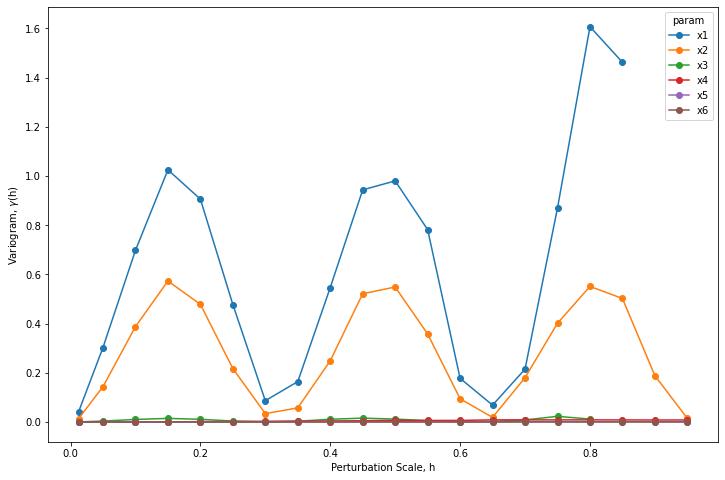

In [47]:
ymax = variogram_value.unstack(0).loc[0:0.6].max().max()
varax = variogram_value.unstack(0).plot(xlabel='Perturbation Scale, h', ylabel='Variogram, $\gamma$(h)', marker='o', figsize=(12,8))

In [61]:
# normalize data using mean normalization
df1 = morris_values[0].unstack(0).iloc[0]
df2 = sobol_value
df3 = ivars_df.loc[0.5]

normalized_maee = df1/df1.sum()
normalized_sobol = df2/df2.sum()
normalized_ivars50 = df3/df3.sum()
display(normalized_sobol)
display(normalized_ivars50)

param
x1    6.392707e-01
x2    3.474000e-01
x3    8.470313e-03
x4    4.162231e-03
x5    6.966889e-04
x6    6.748953e-31
dtype: float64

x1    0.636738
x2    0.351162
x3    0.008289
x4    0.003271
x5    0.000541
x6    0.000000
Name: 0.5, dtype: float64

In [62]:
# if bootstrapping is a thing compute bar chart confidence intervals
# not sure if this will be included in code
ivars50_err_upp = ivars_upp.loc[0.5]/df3.sum()
ivars50_err_low = ivars_low.loc[0.5]/df3.sum()
sobol_err_upp = (sobol_upp/df2.to_numpy().sum()).to_numpy().flatten()
sobol_err_low = (sobol_low/df2.to_numpy().sum()).to_numpy().flatten()

# subtract from normalized values so that error bars work properly
ivars50_err_upp = np.abs(ivars50_err_upp - normalized_ivars50)
ivars50_err_low = np.abs(ivars50_err_low - normalized_ivars50)
sobol_err_upp = np.abs(sobol_err_upp - normalized_sobol)
sobol_err_low = np.abs(sobol_err_low - normalized_sobol)

ivars50_err = np.array([ivars50_err_low, ivars50_err_upp])
sobol_err = np.array([sobol_err_low, sobol_err_upp])

display(ivars50_err)
display(sobol_err)

array([[8.87659021e-02, 1.73692042e-02, 2.43399137e-03, 9.36893872e-04,
        1.81562543e-04, 0.00000000e+00],
       [7.23296159e-02, 8.68478070e-02, 1.42408802e-04, 3.68424319e-04,
        5.83544322e-05, 0.00000000e+00]])

array([[1.92004482e-01, 1.23671007e-01, 3.59723416e-03, 3.00873864e-03,
        2.77091425e-04, 3.18226380e-31],
       [4.54318474e-01, 1.13943222e-01, 1.88534530e-03, 1.63751355e-03,
        5.46568143e-04, 5.19472982e-31]])

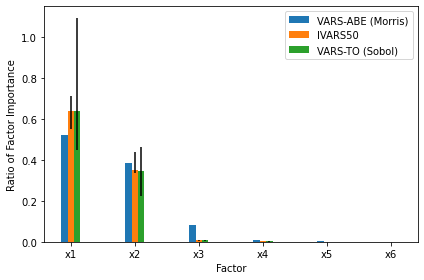

In [63]:
# create barchart
x = np.arange(len(parameters.keys()))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, normalized_maee, width, label='VARS-ABE (Morris)')
rects2 = ax.bar(x, normalized_ivars50, width, label='IVARS50', yerr=ivars50_err)
rects3 = ax.bar(x + width, normalized_sobol, width, label='VARS-TO (Sobol)', yerr=sobol_err)

# Add some text for labels, and custom x-axis tick labels, etc.
ax.set_ylabel('Ratio of Factor Importance')
ax.set_xlabel('Factor')
ax.set_xticks(x)
ax.set_xticklabels(parameters.keys())
ax.legend()

fig.tight_layout()

plt.show()

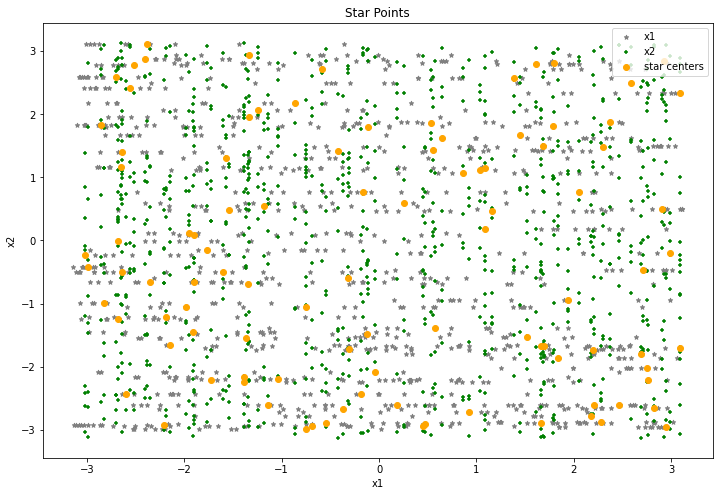

In [65]:
# plot star centres and cross sections of a pair of parameters
ax = star_points_df.unstack(0).loc['x1'].stack(-1).plot.scatter(0, 1, title='Star Points', color='grey', marker='*')
star_points_df.unstack(0).loc['x2'].stack(-1).plot.scatter(0, 1, ax=ax, color='green', marker="+", figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], color='orange')
plt.legend(['x1', 'x2', 'star centers'])

In [54]:
# plot star centres and cross sections of a pair of parameters
np.savetxt("foo2.csv", Z, delimiter=",")

In [51]:
corr_mat

array([[1. , 0. , 0.8, 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. ],
       [0.8, 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. ]])